GAN REFERENCES:
- http://www.rricard.me/machine/learning/generative/adversarial/networks/2017/04/05/gans-part1.html

- https://medium.com/datadriveninvestor/generative-adversarial-network-gan-using-keras-ce1c05cfdfd3


GAN TIPS AND TRICKS:

-https://medium.com/@utk.is.here/keep-calm-and-train-a-gan-pitfalls-and-tips-on-training-generative-adversarial-networks-edd529764aa9

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import Dense, Dropout, Input, BatchNormalization
from keras.models import Model,Sequential
from keras.datasets import mnist
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import adam

C:\Users\Moondra\AppData\Local\Programs\Python\Python36\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # scale to between -1 and 1
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    # convert 3d to 2d
    x_train = x_train.reshape(60000, 784)
    return x_train, y_train, x_test, y_test


In [3]:
x_train, y_train, x_test, y_test = load_data()

In [4]:
print(x_train.shape)

(60000, 784)


In [5]:
x_train_show = x_train.reshape(60000, 28, 28)

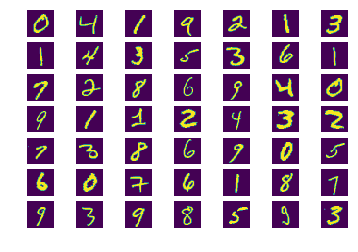

In [6]:
for i in range(1,50):
    plt.subplot(7, 7, i)
    plt.axis('off')
    plt.imshow(x_train_show[i])

plt.show()

In [7]:
def create_generator(input_dim = 100):
    adam_optimizer = adam(lr=0.0002, beta_1=0.5)
    input_layer = Input(shape = (input_dim,))
    x =(Dense(units=256))(input_layer)
    x = LeakyReLU(0.2) (x)
    
    x =(Dense(units=512))(x)
    x = LeakyReLU(0.2) (x)
    
    x =(Dense(units= 1024))(x)
    x = LeakyReLU(0.2) (x)
    
    x =(Dense(units=784, activation='tanh'))(x)
    
    generator = Model(inputs = input_layer, outputs =  x)
    
    generator.compile(loss='binary_crossentropy', optimizer= adam_optimizer)
    return generator

g=create_generator()
g.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
__________

In [8]:
def create_discriminator(input_dim = 784):
    adam_optimizer = adam(lr=0.0002, beta_1=0.5)
    input_layer = Input(shape = (input_dim,))
    x = Dense(units= 1024)(input_layer)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)
       
    x =(Dense(units= 512))(x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.3)(x)
       
    x =Dense(units= 256)(x)
    x = LeakyReLU(0.2) (x)
    x = Dropout(0.3)(x)
    
    output = (Dense(units=1, activation='sigmoid'))(x)
    discriminator = Model(inputs = input_layer, outputs = output)
    discriminator.compile(loss='binary_crossentropy', optimizer=  adam_optimizer)
    return discriminator

d =create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [10]:
#Note needed

def pretrain_discriminator(batch_size, input_size, epochs, plot = False):
    
    losses = []
    d = create_discriminator(input_dim = input_size)
    for i in range(epochs):
        print("Epoch %d"  % i)
        random_fake_data = np.random.normal(loc=0, scale=1, size=[batch_size, input_size])
        real_data= x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]
    
        X= np.concatenate([real_data, random_fake_data])
        Y =np.zeros(2*batch_size)
        Y[:batch_size]=0.9 #label smoothing
        
        loss = d.train_on_batch(X, Y)
        print(loss)
        losses.append(loss)
        
    if plot:
        
        plt.plot(range(epochs), losses, label =  "discrimin_loss")
        plt.show()
    
    return d
        



In [ ]:
pretrain_discriminator(64, 784, 8)

In [11]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    GAN = Sequential()
    GAN.add(generator)
    GAN.add(discriminator)
    GAN.compile(loss='binary_crossentropy', optimizer='adam')
    return GAN


In [12]:
GAN = create_gan(d, g)

In [13]:
print(GAN.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 784)               1486352   
_________________________________________________________________
model_2 (Model)              (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________
None


In [14]:
def plot_generated_images(epoch, generator, examples=100, dim=(10,10), figsize=(10,10)):
    noise= np.random.uniform(low = -1, high=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(100,28,28)
    plt.figure(figsize=figsize)
    for i in range(examples):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('gan_generated_image %d.png' %epoch)

In [ ]:
def training(epochs= 10, batch_size=128):
    d_loss = []
    g_loss = []
    
    # Loading the data
    (x_train, y_train, x_test, y_test) = load_data()
    batch_count = x_train.shape[0] / batch_size
    
    # Creating GAN
    generator= create_generator()
    discriminator = create_discriminator(input_dim = 784)
    gan = create_gan(discriminator, generator)
    
    for e in range(1,epochs+1 ):
        if e % 100 == 0:
            print("Epoch %d" %e)
        for i in range(1):
            # generate data from laten space  to  initialize the  generator
            noise= np.random.uniform(low = -1, high=1, size=[batch_size, 100])
            
            # Generate fake MNIST images from noised input
            generated_images = generator.predict(noise)
            
            # Get a random set of  real images
            image_batch =x_train[np.random.randint(low=0,high=x_train.shape[0],size=batch_size)]
            
            # concat image_batch and generated_images
            X= np.concatenate([image_batch, generated_images])
            
            # Labels for generated and real data
            y=np.zeros(2*batch_size)
            y[:batch_size]=0.9 #label smoothing
            
            #Pre train discriminator on  fake and real data  before starting the gan. 
            discriminator.trainable=True
            loss_1 =discriminator.train_on_batch(X, y)
            
        d_loss.append(loss_1)
        
            
            # Now train generator, get noise with "Real" labels
        noise = np.random.uniform(low= -1, high=1, size=[batch_size * 8, 100])
        y_gen = np.ones(batch_size * 8)
        y_gen[:] = .9

        # Turn off discrimnator training
        discriminator.trainable=False

        #train GAN ()   
        loss_2 = gan.train_on_batch(noise, y_gen)
        g_loss.append(loss_2)
        
        
       
            
        if e % 200 == 0:
            
            print('d_loss', loss_1)
            print('g_loss', loss_2) 
           
            plot_generated_images(e, generator)
            
    return d_loss, g_loss
d_loss, g_loss = training(epochs = 2000,batch_size =128)

Epoch 100
Epoch 200
d_loss 0.5272736
g_loss 2.0853577
